In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from tqdm import tqdm
import utils.augmentation as aug

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

seed = 42

2.10.0


In [5]:
training_labels = {
    "Wish": 0,
    "Another": 1,
    "Comfortably": 2,
    "Money": 3,
    "Breathe": 4,
    "Time": 5,
    "Brain": 6,
    "Echoes": 7,
    "Wearing": 8,
    "Sorrow": 9,
    "Hey": 10,
    "Shine": 11,
}

### DATA PREPARATION

In [6]:
data = np.load("../../data/x_train.npy")
target = np.load("../../data/y_train.npy")

In [7]:
#SHUFFLE DATA
p = np.random.permutation(data.shape[0])
data = data[p]
target = target[p]

In [8]:
data[0].shape

(36, 6)

In [9]:
#NAME OF THE FEATURES COLUMNS
feature_names = ['Attribute-0', 'Attribute-1', 'Attribute-2', 'Attribute-3', 'Attribute-4', 'Attribute-5']
#COLUMNS NAMES (include ID and TARGET and all features)
columns = feature_names.copy()
columns.insert(0, 'ID')
columns.append('Target')

In [10]:
def add_shift(df, column_names=None, shift=1, avg=False):
    if column_names is None:
        column_names = []
    if avg:
        new_columns = [item + " - A" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].rolling(shift).mean()
    else:
        new_columns = [item + " - S" + str(shift) for item in column_names]
        df[new_columns] = df[column_names].shift(shift)

    #Replace Nan with 0
    df[new_columns] = df[new_columns].replace(np.nan, 0)
    return df

In [11]:
X = pd.DataFrame(columns=columns)
remove_shifts = True
for i in tqdm(range(0, data.shape[0])):
    new_seq = pd.DataFrame(data[i], columns=feature_names)
    new_seq['Target'] = target[i]
    new_seq['ID'] = i
    if not remove_shifts:
        new_seq = add_shift(new_seq, feature_names, shift=2)
        new_seq = add_shift(new_seq, feature_names, shift=5)
        new_seq = add_shift(new_seq, feature_names, shift=5, avg=True)
        new_seq = add_shift(new_seq, feature_names, shift=10)
        new_seq = add_shift(new_seq, feature_names, shift=10, avg=True)
    X = pd.concat([X, new_seq])

X.shape

100%|██████████| 2429/2429 [00:02<00:00, 911.91it/s] 


(87444, 8)

In [12]:
X

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,6.19200,-2.36660,-1.0171,0.65388,-9.49910,-4.1691,3
1,0,4.61080,0.20635,1.9466,1.95660,0.87392,7.1599,3
2,0,-0.16761,1.20150,-2.7017,-4.46260,-6.62740,-14.7480,3
3,0,2.64520,6.29010,11.9080,7.05890,7.30350,73.7540,3
4,0,0.80411,107.56000,141.9300,121.60000,115.71000,131.8400,3
...,...,...,...,...,...,...,...,...
31,2428,-3.94660,15.08500,-42.6060,-5.84000,-51.09300,16.5950,2
32,2428,-4.22340,12.53600,-57.0700,2.39310,-2.95940,-46.8120,2
33,2428,-2.38350,6.70060,-27.9040,43.13000,-18.61800,41.5170,2
34,2428,-0.36406,1.80310,8.7911,44.01900,-19.94300,3.6606,2


In [13]:
feature_names = X.columns[X.columns != 'ID']
feature_names = feature_names[feature_names != 'Target']
feature_names = feature_names.tolist()
feature_names

['Attribute-0',
 'Attribute-1',
 'Attribute-2',
 'Attribute-3',
 'Attribute-4',
 'Attribute-5']

In [14]:
X

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,6.19200,-2.36660,-1.0171,0.65388,-9.49910,-4.1691,3
1,0,4.61080,0.20635,1.9466,1.95660,0.87392,7.1599,3
2,0,-0.16761,1.20150,-2.7017,-4.46260,-6.62740,-14.7480,3
3,0,2.64520,6.29010,11.9080,7.05890,7.30350,73.7540,3
4,0,0.80411,107.56000,141.9300,121.60000,115.71000,131.8400,3
...,...,...,...,...,...,...,...,...
31,2428,-3.94660,15.08500,-42.6060,-5.84000,-51.09300,16.5950,2
32,2428,-4.22340,12.53600,-57.0700,2.39310,-2.95940,-46.8120,2
33,2428,-2.38350,6.70060,-27.9040,43.13000,-18.61800,41.5170,2
34,2428,-0.36406,1.80310,8.7911,44.01900,-19.94300,3.6606,2


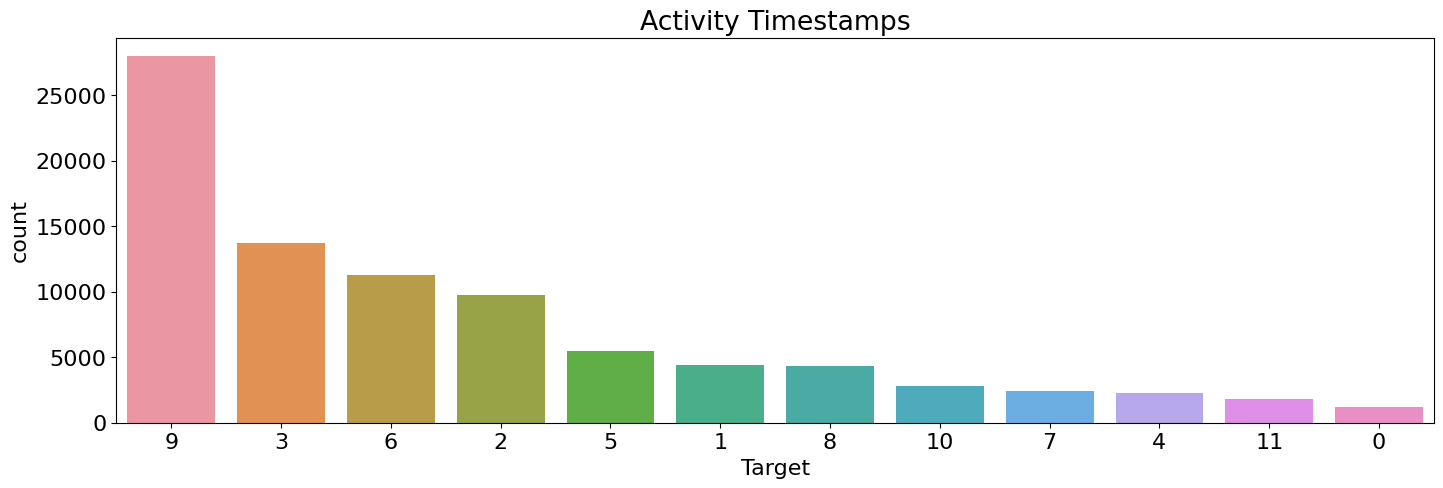

In [15]:
# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=X, order=X.Target.value_counts().index)
plt.title('Activity Timestamps')
plt.show()

### DISPLAY DATA

In [16]:
X.iloc[[0]]


,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,6.192,-2.3666,-1.0171,0.65388,-9.4991,-4.1691,3


In [17]:
def inspect_activity(activity, df):
    data = df[df['Target'] == activity][feature_names]
    axis = data.plot(subplots=True, figsize=(17, 9), title=activity)
    for ax in axis:
        ax.legend(loc='lower right')

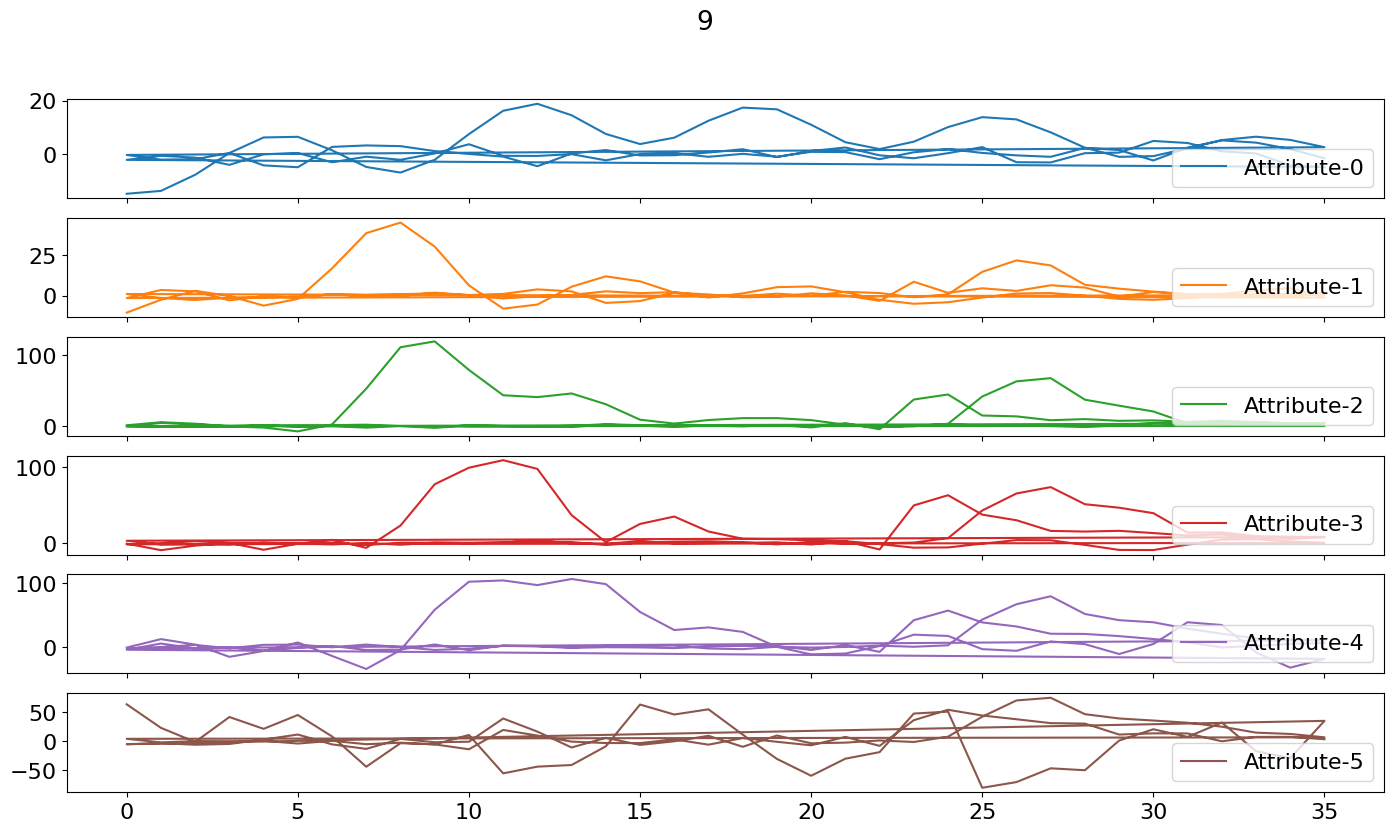

In [18]:
class_to_plot = 9
inspect_activity(class_to_plot, X.head(360))

# SPLIT DATA INTO TRAIN / TEST
- Split data into Train and test seqeuences using sequence ID
- We also convert target into OneHotEncoding
- Normalize Data using MinMax Scaler


In [19]:
test_split = 0.2
test_split_ID = data.shape[0] - test_split * data.shape[0]

# Split over users
df_train = X[X['ID'] <= test_split_ID]
df_test = X[X['ID'] > test_split_ID]
X.set_index('ID')
df_train.shape, df_test.shape

((69984, 8), (17460, 8))

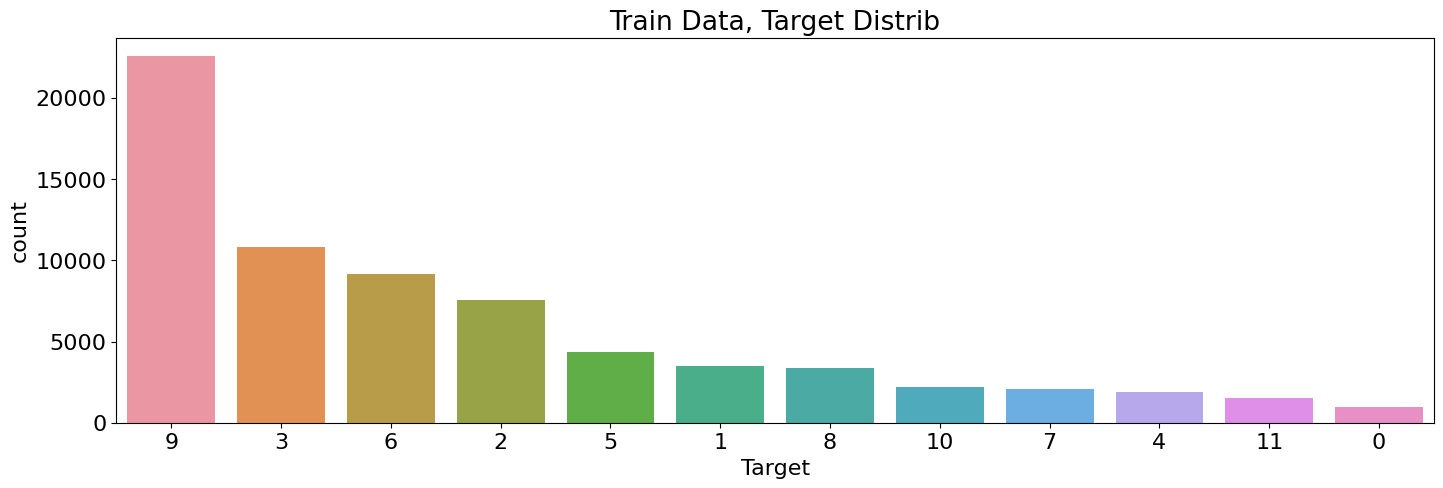

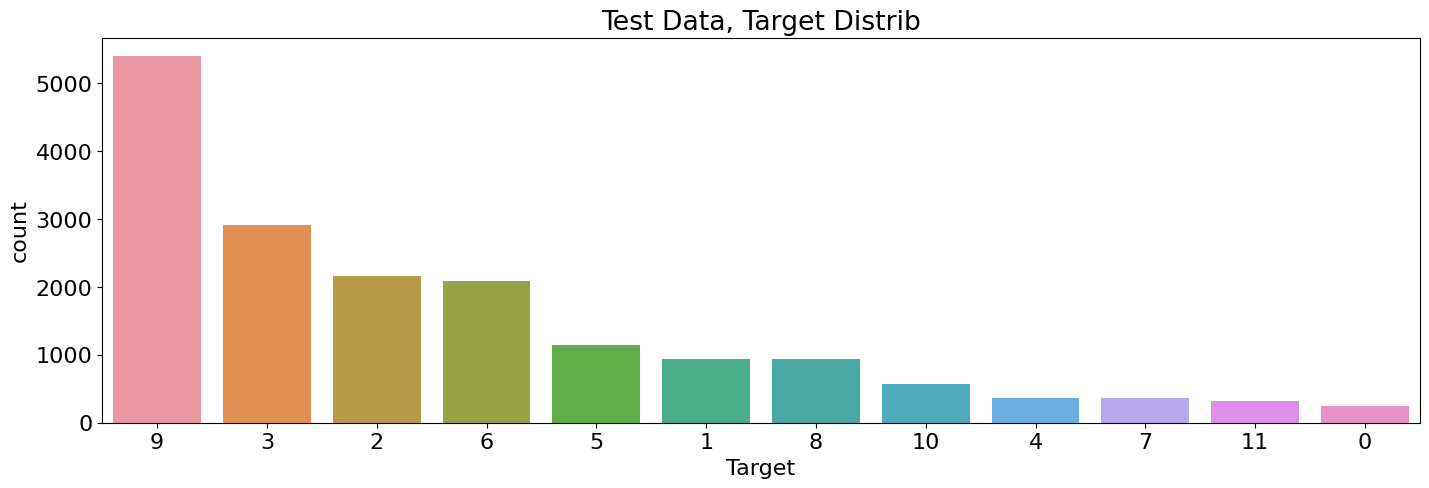

In [20]:
# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=df_train, order=df_train.Target.value_counts().index)
plt.title('Train Data, Target Distrib')
plt.show()

# Inspect activities timestamps
plt.figure(figsize=(17, 5))
sns.countplot(x='Target', data=df_test, order=df_test.Target.value_counts().index)
plt.title('Test Data, Target Distrib')
plt.show()

In [21]:
df_train

,ID,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target
0,0,6.19200,-2.36660,-1.0171,0.65388,-9.49910,-4.1691,3
1,0,4.61080,0.20635,1.9466,1.95660,0.87392,7.1599,3
2,0,-0.16761,1.20150,-2.7017,-4.46260,-6.62740,-14.7480,3
3,0,2.64520,6.29010,11.9080,7.05890,7.30350,73.7540,3
4,0,0.80411,107.56000,141.9300,121.60000,115.71000,131.8400,3
...,...,...,...,...,...,...,...,...
31,1943,-11.63200,-16.25300,-23.6240,-15.15500,-11.58000,-4.0790,6
32,1943,-16.07200,-19.10300,-18.4330,-14.17600,-8.13600,-8.8490,6
33,1943,-19.56600,-20.19400,-17.0870,-14.10500,-24.18500,-24.1490,6
34,1943,-17.05400,-16.09600,-22.2380,-20.71700,6.39010,-48.6090,6


In [22]:
def normalizeSingleSerie(df):
  t = df.groupby('ID',group_keys=False)
  t = t[feature_names].apply(lambda x: (x - x.mean()) / x.std())
  t['Target'] = df['Target']
  t['ID'] = df['ID']
  return pd.DataFrame(t)

In [23]:
# Apply MinMaxScaler to the useful features
normalize = True
norm_type = 2  # 0 -> MinMax, 1 Mean(0) Std dev(1)

#NORMALIZE DATA
if normalize:
    #MinMax
    if norm_type == 0:
        min = df_train[feature_names].min()
        max = df_train[feature_names].max()
        df_train[feature_names] = (df_train[feature_names] - min) / (max - min)
        df_test[feature_names] = (df_test[feature_names] - min) / (max - min)
    #Mean,Std
    if norm_type == 1:
        mean = df_train[feature_names].mean()
        var = df_train[feature_names].std()
        df_train[feature_names] = (df_train[feature_names] - mean) / var
        df_test[feature_names] = (df_test[feature_names] - mean) / var

    if norm_type == 2:
        df_train = normalizeSingleSerie(df_train)
        df_test = normalizeSingleSerie(df_test)
df_train

,Attribute-0,Attribute-1,Attribute-2,Attribute-3,Attribute-4,Attribute-5,Target,ID
0,2.671078,-0.498023,-0.608103,-0.621921,-0.807922,-0.731495,3,0
1,1.908264,-0.405268,-0.542513,-0.594266,-0.599377,-0.504300,3,0
2,-0.396973,-0.369392,-0.645385,-0.730536,-0.750188,-0.943647,3,0
3,0.960004,-0.185948,-0.322057,-0.485952,-0.470113,0.831199,3,0
4,0.071812,3.464843,2.555473,1.945584,1.709354,1.996074,3,0
...,...,...,...,...,...,...,...,...
31,0.979057,0.695863,-1.378014,0.188193,0.343048,0.799227,6,1943
32,0.048506,-0.329368,0.040723,0.354279,0.617109,0.600775,6,1943
33,-0.683778,-0.721834,0.408594,0.366324,-0.660010,-0.035771,6,1943
34,-0.157305,0.752341,-0.999211,-0.755394,1.773041,-1.053410,6,1943


In [24]:
def build_sequence(df):
    x = df.groupby('ID')[feature_names].apply(lambda x: x.values.tolist()).tolist()
    y = df.groupby(['ID', 'Target'])[['Target']].mean()

    return np.array(x), np.array(y)

In [25]:
x_train, y_train = build_sequence(df_train)
x_test, y_test = build_sequence(df_test)
#X,Y = build_sequence(X) -> TEST IF TARGET ARE EXTRACTED IN CORRECT ORDER (WORK)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1944, 36, 6), (1944, 1), (485, 36, 6), (485, 1))

# Augmentation

In [26]:
import utils.augmentation as aug

In [27]:
def plot_aug(x, x_aug):
    # color red for original and green for augmented
    plt.plot(x, color='red')
    plt.plot(x_aug, color='green')




series = x_train

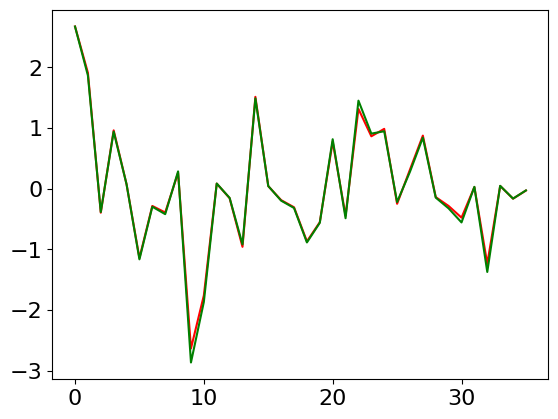

In [28]:
plot_aug(series[0, :, 0],  aug.magnitude_warp(series, sigma=0.1, knot=10)[0, :, 0])


1. Random Noise Injection: This function adds random noise to the data series in order to increase the variability of the data and make it more suitable for a neural network.

In [29]:

def random_noise_injection(data, sigma=0.001):
    noise = np.random.normal(0, sigma, data.shape)
    return data + noise


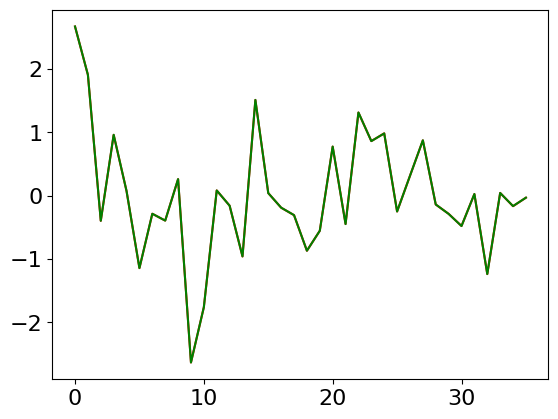

In [30]:
x_noise = random_noise_injection(x_train )
plot_aug(x_train[0, :, 0], x_noise[0, :, 0])

2. Data Scaling: This function scales the data series to a range between 0 and 1, which is a common pre-processing step for neural networks.

In [31]:

def data_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)


3. Data Augmentation: This function randomly flips, rotates, and shifts the data series in order to create new data points.

In [32]:

def data_augmentation(data):
    augmented_data = np.copy(data)
    for i in range(data.shape[0]):
        if np.random.rand() > 0.5:
            augmented_data[I] = np.flip(data[i])
        if np.random.rand() > 0.5:
            augmented_data[I] = np.rot90(data[i])
        if np.random.rand() > 0.5:
            augmented_data[i] = np.roll(data[i], np.random.randint(1, data.shape[1]))
    return augmented_data

In [33]:
x_train, y_train = build_sequence(df_train)
x_test, y_test = build_sequence(df_test)
#X,Y = build_sequence(X) -> TEST IF TARGET ARE EXTRACTED IN CORRECT ORDER (WORK)


x_train = np.append(x_train, aug.jitter(x_train, sigma=0.1)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
x_train = np.append(x_train, aug.magnitude_warp(series, sigma=0.1, knot=10)[:2000], axis=0)
y_train = np.append(y_train, y_train[:2000])
# x_train = np.append(x_train, aug.permutation(series, max_segments=3)[:1000], axis=0)
# y_train = np.append(y_train, y_train[:1000])

indexes = np.random.choice(x_train.shape[0], x_train.shape[0])
x_train = x_train[indexes]
y_train = y_train[indexes]

In [34]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5832, 36, 6), (5832, 12), (485, 36, 6), (485, 12))

# NOW USE THE GENERATED TIME SERIES TO TRAIN OUR MODELS

Vanilla Attempts:
-CNN1D : 

In [61]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200
input_shape, classes, y_train.shape

((36, 6), 12, (5832, 12))

### CNN-1D Basic model

In [62]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')


    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor


    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [63]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_29 (LSTM)              (None, 36, 32)            4992      
                                                                 
 dropout_19 (Dropout)        (None, 36, 32)            0         
                                                                 
 lstm_30 (LSTM)              (None, 36, 32)            8320      
                                                                 
 dropout_20 (Dropout)        (None, 36, 32)            0         
                                                                 
 lstm_31 (LSTM)              (None, 36, 64)            24832     
                                                                 
 dropout_21 (Dropout)        (None, 36, 64)            0     

In [64]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-14 19:04:04.016707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.374751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.478251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.555203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.634327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.710761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:04.787753: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0740 - accuracy: 0.3190

2022-12-14 19:04:10.092925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.224268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.305734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.394933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.484372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.570420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:04:10.654865: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 11s 135ms/step - loss: 2.0740 - accuracy: 0.3190 - val_loss: 1.8615 - val_accuracy: 0.3442 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 3s 76ms/step - loss: 1.7636 - accuracy: 0.4051 - val_loss: 1.5741 - val_accuracy: 0.4983 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 3s 74ms/step - loss: 1.5917 - accuracy: 0.4672 - val_loss: 1.4611 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 3s 76ms/step - loss: 1.4952 - accuracy: 0.4947 - val_loss: 1.3717 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 3s 75ms/step - loss: 1.4044 - accuracy: 0.5185 - val_loss: 1.2604 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 3s 76ms/step - loss: 1.3511 - accuracy: 0.5417 - val_loss: 1.2434 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 3s 75ms/step - loss: 1.3154

In [65]:
#model.save('Preprocess-CNN')

In [66]:
# Predict the test set with the 1DCNN
predictions = model.predict(x_test)
predictions.shape

2022-12-14 19:12:53.289071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:12:53.525834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:12:53.696132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:12:53.848505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:12:53.923112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-14 19:12:53.996955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 2/16 [==>...........................] - ETA: 0s 

2022-12-14 19:12:54.094002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 3s 79ms/step


(485, 12)

Accuracy: 0.5175
Precision: 0.3898
Recall: 0.3579
F1: 0.3664


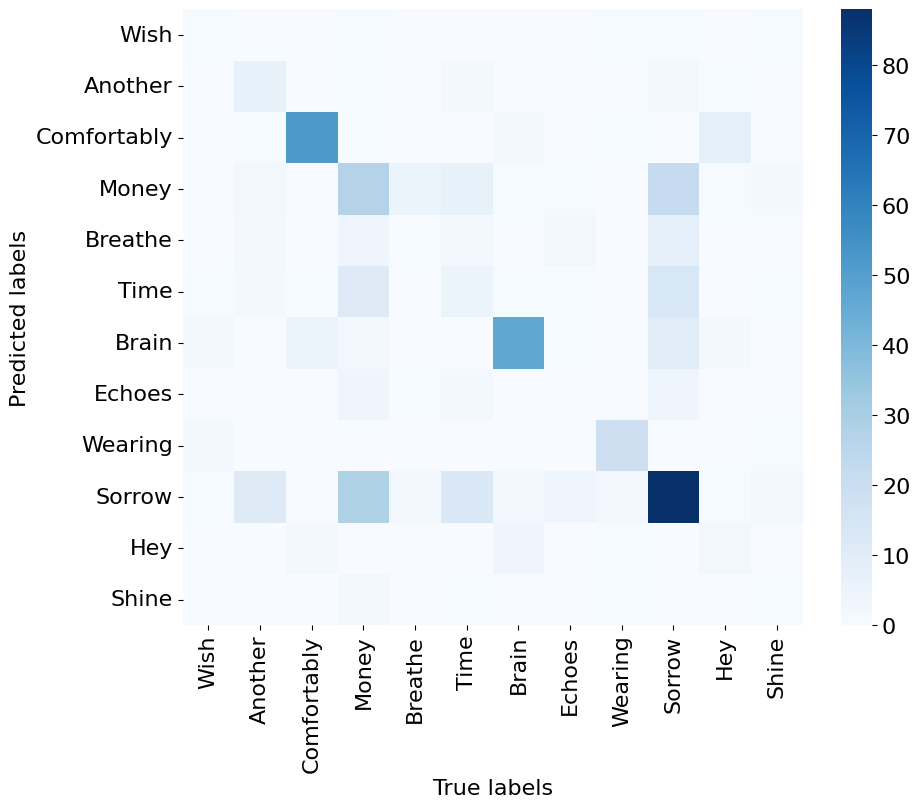

In [67]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Vanilla LSTM

In [1]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200
input_shape, classes


def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')


    lstm = tfkl.LSTM(16, return_sequences=True)(input_layer)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(16, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(32, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(64, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.4, seed=seed)(lstm)
    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor
    dropout = tfkl.Dropout(.3, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(512, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [2]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

NameError: name 'input_shape' is not defined

In [ ]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-14 19:13:08.030143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [1]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'model' is not defined

### Bidirectional-LSTM

In [300]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [301]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 36, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                             

In [302]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


2022-12-12 19:38:52.800049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.134638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.302474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.423981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.615116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:38:53.631122: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 2.0191 - accuracy: 0.3544

2022-12-12 19:39:00.703929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.834830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:00.843495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.004557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.013282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.181292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-12 19:39:01.191254: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - 12s 172ms/step - loss: 2.0191 - accuracy: 0.3544 - val_loss: 1.6861 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/200
41/41 [==============================] - 4s 89ms/step - loss: 1.6565 - accuracy: 0.4285 - val_loss: 1.5348 - val_accuracy: 0.5051 - lr: 0.0010
Epoch 3/200
41/41 [==============================] - 4s 87ms/step - loss: 1.5245 - accuracy: 0.4705 - val_loss: 1.4584 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 4/200
41/41 [==============================] - 4s 99ms/step - loss: 1.4548 - accuracy: 0.4882 - val_loss: 1.4107 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 5/200
41/41 [==============================] - 4s 88ms/step - loss: 1.3972 - accuracy: 0.4987 - val_loss: 1.4095 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3546 - accuracy: 0.5158 - val_loss: 1.3105 - val_accuracy: 0.5599 - lr: 0.0010
Epoch 7/200
41/41 [==============================] - 3s 85ms/step - loss: 1.3160

In [303]:
#model.save('Preprocessing-BiLSTM')

16/16 [==============================] - 1s 47ms/step
Accuracy: 0.5134
Precision: 0.5267
Recall: 0.4317
F1: 0.4572


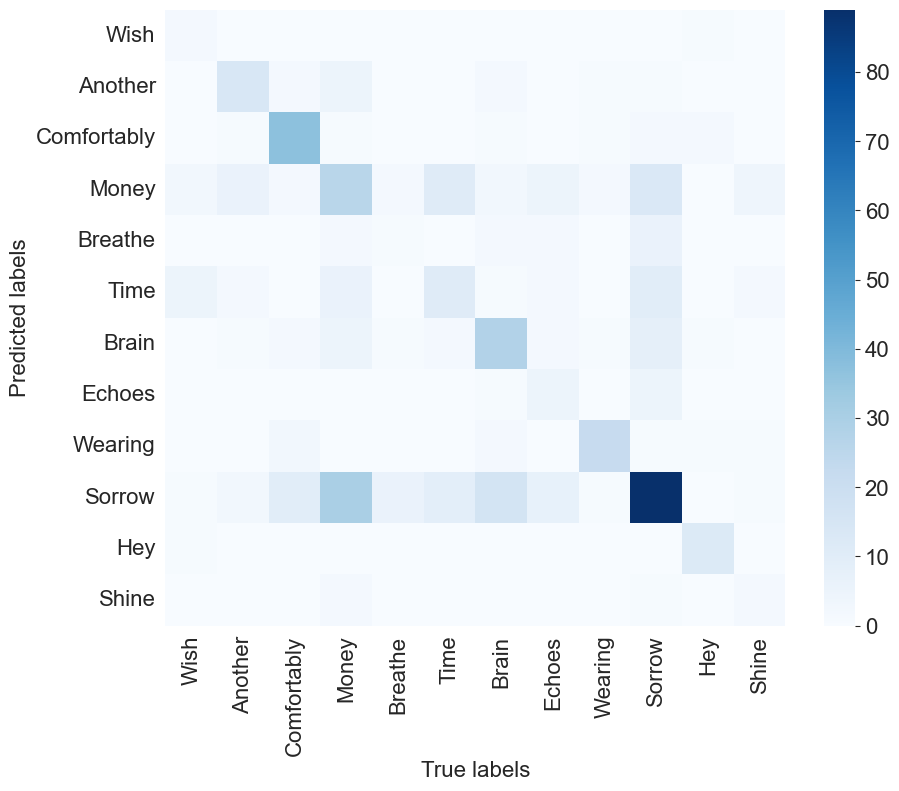

In [305]:
# Predict the test set with the model
predictions = model.predict(x_test)
predictions.shape
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(training_labels.keys()), yticklabels=list(training_labels.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### HYBRID CNN-LSTM


In [66]:
def build_Hybrid(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256, 7, padding='same', activation='relu')(input_layer)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.2, seed=seed)(gap)

    lstm = tfkl.LSTM(128, return_sequences=True)(dropout)  #PRESERVE THE TEMPORAL DIMENSION (200, size of window)
    lstm = tfkl.LSTM(128)(lstm)  #NOT PRESERVE TIME SINCE WE KEEP ONLY LAST ONE
    dropout = tfkl.Dropout(.2, seed=seed)(lstm)

    # IN OUTPUT OF LSTM: we have a tensor that represent the output of the memory cells (only of the last one!!!)
    #LSTM CHAIN is like a feature extractor

    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(dropout)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model